In [47]:
import xarray as xr

zarr_path = './seasfire_v0.4.zarr'
ds = xr.open_zarr(zarr_path, consolidated=False)

In [48]:
# Check the dataset structure in detail
print("Dataset info:")
print(ds)
print("\nDimensions:")
print(ds.dims)
print("\nCoordinates:")
print(ds.coords)
print("\nData variables:")
print(ds.data_vars)
print("\nCoordinate names vs dimension names:")
print("Coord names:", list(ds.coords.keys()))
print("Dim names:", list(ds.dims.keys()))

Dataset info:
<xarray.Dataset> Size: 164GB
Dimensions:                         (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
Data variables: (12/59)
    oci_ea                          (time) float32 4kB ...
    t2m_max                         (time, latitude, longitude) float32 4GB ...
    ws10                            (time, latitude, longitude) float32 4GB ...
    pop_dens                        (time, latitude, longitude) float32 4GB ...
    cams_co2fire                    (time, latitude, longitude) float32 4GB ...
    oci_soi                         (time) float32 4kB ...
    ...                              ...
    swvl1                           (time, latitude, longitude) float32 4GB ...
    lai                             (time, lat

/var/folders/90/7phr6sbs5px7bcmkbnk_kb400000gp/T/ipykernel_94129/1374725965.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dim names:", list(ds.dims.keys()))


In [49]:
# Select California
lat_min, lat_max = 32, 42
lon_min, lon_max = -125, -114

ds_ca = ds.sel(
    latitude=slice(lat_max, lat_min),  # descending latitude
    longitude=slice(lon_min, lon_max)
)
print(ds_ca)

<xarray.Dataset> Size: 279MB
Dimensions:                         (time: 966, latitude: 40, longitude: 44)
Coordinates:
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
  * longitude                       (longitude) float64 352B -124.9 ... -114.1
  * latitude                        (latitude) float64 320B 41.88 ... 32.12
Data variables: (12/59)
    oci_ea                          (time) float32 4kB ...
    t2m_max                         (time, latitude, longitude) float32 7MB ...
    ws10                            (time, latitude, longitude) float32 7MB ...
    pop_dens                        (time, latitude, longitude) float32 7MB ...
    cams_co2fire                    (time, latitude, longitude) float32 7MB ...
    oci_soi                         (time) float32 4kB ...
    ...                              ...
    swvl1                           (time, latitude, longitude) float32 7MB ...
    lai                             (time, latitude, longitude

# Features
| Feature             | Description                                                                           | Relevance for Fire & Climate                                                          |
| ------------------- | ------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| `cams_co2fire`      | CO₂ emissions from fires estimated by CAMS (Copernicus Atmosphere Monitoring Service) | Measures greenhouse gas emissions from fire events; helps study climate feedbacks     |
| `cams_frpfire`      | Fire Radiative Power (FRP) from CAMS                                                  | Indicates fire intensity and energy release                                           |
| `fcci_ba`           | Burned area from ESA Fire CCI (Fire Climate Change Initiative)                        | Direct measure of fire extent; essential for studying fire frequency and severity     |
| `gfed_ba`           | Burned area from GFED (Global Fire Emissions Database)                                | Alternative burned area estimate; useful for validation and cross-comparison          |
| `gwis_ba`           | Burned area from GWIS (Global Wildfire Information System)                            | Another independent burned area dataset for monitoring global fires                   |
| `fwi_max`           | Maximum Fire Weather Index                                                            | Shows the highest fire risk based on weather conditions                               |
| `fwi_mean`          | Mean Fire Weather Index                                                               | Average fire risk over a given time period                                            |
| `drought_code_max`  | Maximum Drought Code                                                                  | Indicates the severity of long-term drying of forest fuels                            |
| `drought_code_mean` | Mean Drought Code                                                                     | Average moisture deficit in fuels; helps assess cumulative drought impact             |
| `lai`               | Leaf Area Index                                                                       | Amount of leaf area per unit ground; higher LAI = more fuel for fires                 |
| `ndvi`              | Normalized Difference Vegetation Index                                                | Vegetation health and greenness; low NDVI = dry vegetation → higher fire risk         |
| `t2m_max`           | Maximum 2m Air Temperature                                                            | High daytime temperatures increase drying of fuels                                    |
| `t2m_mean`          | Mean 2m Air Temperature                                                               | Overall thermal conditions affecting fire risk                                        |
| `t2m_min`           | Minimum 2m Air Temperature                                                            | Nighttime temperatures; influences vegetation recovery and soil moisture              |
| `tp`                | Total Precipitation                                                                   | Rainfall replenishes soil and vegetation moisture, reducing fire risk                 |
| `rel_hum`           | Relative Humidity                                                                     | Low humidity dries fuels; high humidity suppresses fires                              |
| `ws10`              | 10m Wind Speed                                                                        | Strong winds increase fire spread and intensity                                       |
| `vpd`               | Vapor Pressure Deficit                                                                | Drying power of the air; high VPD → high fire risk                                    |
| `mslp`              | Mean Sea Level Pressure                                                               | Influences regional weather patterns; can affect fire conditions indirectly           |
| `skt`               | Skin Temperature                                                                      | Surface temperature; affects soil and vegetation moisture                             |
| `sst`               | Sea Surface Temperature                                                               | Impacts local climate and atmospheric moisture, indirectly affecting fire risk        |
| `ssr`               | Surface Solar Radiation                                                               | Incoming solar energy; high SSR dries vegetation and fuels                            |
| `ssrd`              | Surface Solar Radiation Downwards                                                     | Another measure of incoming solar energy on the surface                               |
| `swvl1`             | Soil Water Volume Layer 1                                                             | Top-layer soil moisture (0–10 cm); low values indicate dry soils and higher fire risk |

In [ ]:
# List of variables relevant for fire -> climate impact
fire_climate_vars = [
    # Fire activity / emissions
    "cams_co2fire",
    "cams_frpfire",
    "fcci_ba",
    "gfed_ba",
    "gwis_ba",
    "fwi_max",
    "fwi_mean",
    "drought_code_max",
    "drought_code_mean",

    # Vegetation / land surface
    "lai",
    "ndvi",
    "lst_day",
    # "lccs_class_0",
    # "lccs_class_1",
    # "lccs_class_2",
    # "lccs_class_3",
    # "lccs_class_4",
    # "lccs_class_5",
    # "lccs_class_6",
    # "lccs_class_7",
    # "lccs_class_8",
    "lsm",

    # Climate / meteorology
    "t2m_max",
    "t2m_mean",
    "t2m_min",
    "tp",
    "rel_hum",
    "ws10",
    "vpd",
    "mslp",
    "skt",
    "sst",
    "ssr",
    "ssrd",
    "swvl1",

    # Human factors
    "pop_dens"
]

# Select only the variables of interest
ds_ca = ds_ca[fire_climate_vars]

# Load data into memory (optional, or work with lazy loading)
ds = ds_ca.load()

size_bytes = ds.nbytes
print(f"Dataset size: {size_bytes/1024**2:.2f} Mb")


Dataset size: 265.99 Mb


In [51]:
!pip install scikit-learn

In [52]:
!pip install matplotlib

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import sklearn
import matplotlib.pyplot as plt

In [62]:
print(sklearn.__version__)
print("Dimensions:", ds_ca.dims)
print("Coordinates:", ds_ca.coords)

1.7.1
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 966, 'latitude': 40, 'longitude': 44})
Coordinates: Coordinates:
  * time       (time) datetime64[ns] 8kB 2001-01-01 2001-01-09 ... 2021-12-27
  * longitude  (longitude) float64 352B -124.9 -124.6 -124.4 ... -114.4 -114.1
  * latitude   (latitude) float64 320B 41.88 41.62 41.38 ... 32.62 32.38 32.12


In [55]:
# Step 1: Stack lat and lon into z

# Convert to pandas DataFrame
df = ds_ca.to_dataframe()

# Create column 'z' from latitude and longitude indexes
# Replace missing values with placeholder if needed
lat_index = df.index.get_level_values('latitude').fillna('missing')
lon_index = df.index.get_level_values('longitude').fillna('missing')

df['z'] = list(zip(lat_index, lon_index))

# Optional: drop rows with missing values
#df = df.dropna()

print(f"Shape: {df.shape}")
df_z = df[['z']]
print(df_z.head())

data = df

Shape: (1700160, 60)
                                                z
time       latitude longitude                    
2001-01-01 41.875   -124.875   (41.875, -124.875)
                    -124.625   (41.875, -124.625)
                    -124.375   (41.875, -124.375)
                    -124.125   (41.875, -124.125)
                    -123.875   (41.875, -123.875)


In [56]:
# Step 2: Create lag features (1-month lag of burned area to simulate fire history)
data['gfed_ba_lag1'] = data.groupby('z')['gfed_ba'].shift(1)

In [57]:
# Step 3: Define features (X) and target (y)
features = ['gfed_ba_lag1', 'vpd', 'ndvi', 'lai', 't2m_mean', 'rel_hum']
target = 'swvl1'

data_clean = data.dropna(subset=[target])

X = data_clean[features]
y = data_clean[target]

In [ ]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Step 5: Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
# Step 6: Evaluate model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Model R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f}")

Model R²: 0.791
RMSE: 0.0038


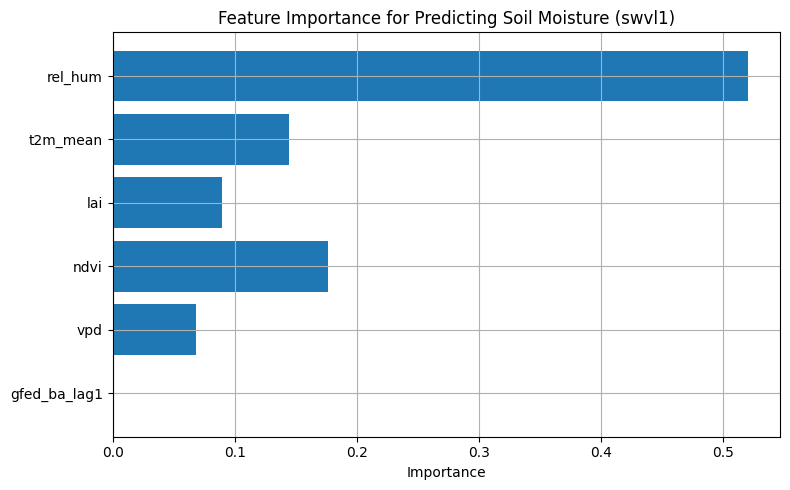

In [64]:
# Step 7: Feature Importance Plot
importances = model.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.title("Feature Importance for Predicting Soil Moisture (swvl1)")
plt.xlabel("Importance")
plt.grid()
plt.tight_layout()
plt.show()